## EDA Analysis

In [5]:
import torch
print("torch.__version__: ",torch.__version__)
torch.cuda.is_available()
import os, glob, random, time, gc
from tqdm.notebook import tqdm
from tqdm import tqdm

import tifffile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from torch.utils.data import Dataset

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

torch.__version__:  2.0.1+cu117


In [6]:
# import dataset
PATH_IMG_ROOT = './data/train_true_color/'
PATH_LBL_ROOT = '/data/train_mask/'
PATH_OUTPUT = './eda/'

BANDS = ['B02', 'B03', 'B04']
COLORS = ['#0000ff', '#00ff7f', 'darkorange']
CMAPS = ['Blues', 'Greens', 'Reds']

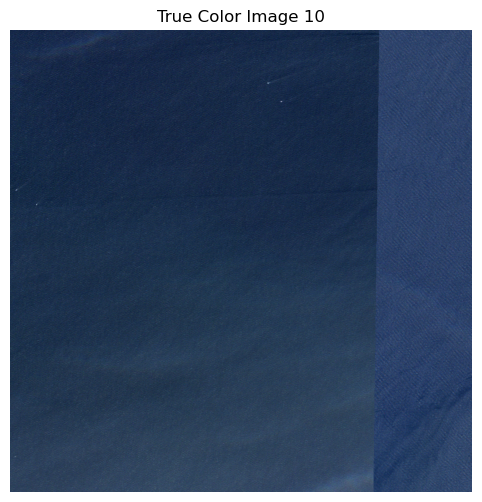

In [7]:
def normalize_image_to_8bit(img):
    """Normalize the image to fit within [0, 255] range."""
    img_normalized = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return img_normalized

def display_true_color_image(image_idx):
    """Display an image in its original color."""
    
    # Construct image path
    img_path = f"./data/train_true_color/train_true_color_{image_idx}.tif"
    
    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    
    # Normalize to 8-bit
    img_8bit = normalize_image_to_8bit(img)

    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title(f'True Color Image {image_idx}')
    plt.axis('off')  # To hide axis values
    plt.show()

# Image index to visualize
image_idx = 10

display_true_color_image(image_idx)


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image_and_histogram(image_idx):
    """Display the three bands and their histograms for a given image index."""
    img_path = f"./data/train_true_color/train_true_color_{image_idx}.tif"
    mask_path = f"./data/train_mask/train_mask_{image_idx}.tif"

    # Load the image and its corresponding mask
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    # Split the three bands
    B2, B3, B4 = cv2.split(img)

    BANDS = ['B02', 'B03', 'B04']
    COLORS = ['#0000ff', '#00ff7f', 'darkorange']
    CMAPS = ['Blues', 'Greens', 'Reds']
    bands = [B2, B3, B4]

    plt.figure(figsize=(18, 10))

    # Display the bands
    for idx, (band, cmap, title, color) in enumerate(zip(bands, CMAPS, BANDS, COLORS)):
        ax = plt.subplot(3, 4, idx + 1)
        img = ax.imshow(band, cmap=cmap)
        
        mean = np.mean(band)
        median = np.median(band)
        std_dev = np.std(band)
        min_val = np.min(band)
        max_val = np.max(band)
        
        stats_text = f'Mean: {mean:.2f}\nMedian: {median:.2f}\nStd: {std_dev:.2f}'
        
        # Display statistics below the image
        ax.set_xlabel(stats_text, color=color, fontsize=10)
        
        plt.title(f'Image {image_idx} {title}', color=color)
        plt.colorbar(img, ax=ax, orientation='vertical')
        

    # Display the corresponding mask/label
    plt.subplot(3, 4, 4)
    import matplotlib.colors as mcolors
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", ['black', 'yellow'])
    plt.imshow(mask,cmap=custom_cmap)
    plt.title('Mask')

    # Display filled histograms for the bands
    for idx, (band, title, color) in enumerate(zip(bands, BANDS, COLORS)):
        plt.subplot(3, 4, idx + 5)
        plt.hist(band.ravel(), color=color, bins=300, range=(300, 8000))
        plt.title(f'Image {image_idx} {title}', color=color)
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.tight_layout()

    plt.show()

# List of image indices to visualize
image_indices = [4, 200, 301]  # Extend this list as needed

for idx in image_indices:
    display_image_and_histogram(idx)


[ WARN:0@2.167] global loadsave.cpp:248 findDecoder imread_('./dataset/train_true_color/train_true_color_4.tif'): can't open/read file: check file path/integrity
[ WARN:0@2.167] global loadsave.cpp:248 findDecoder imread_('./dataset/train_mask/train_mask_4.tif'): can't open/read file: check file path/integrity


ValueError: not enough values to unpack (expected 3, got 0)

### Cloud Coverage

Mean Cloud Coverage: 19.47%
Median Cloud Coverage: 5.75%
Standard Deviation: 26.96
Minimum Cloud Coverage: 0.00%
Maximum Cloud Coverage: 100.00%


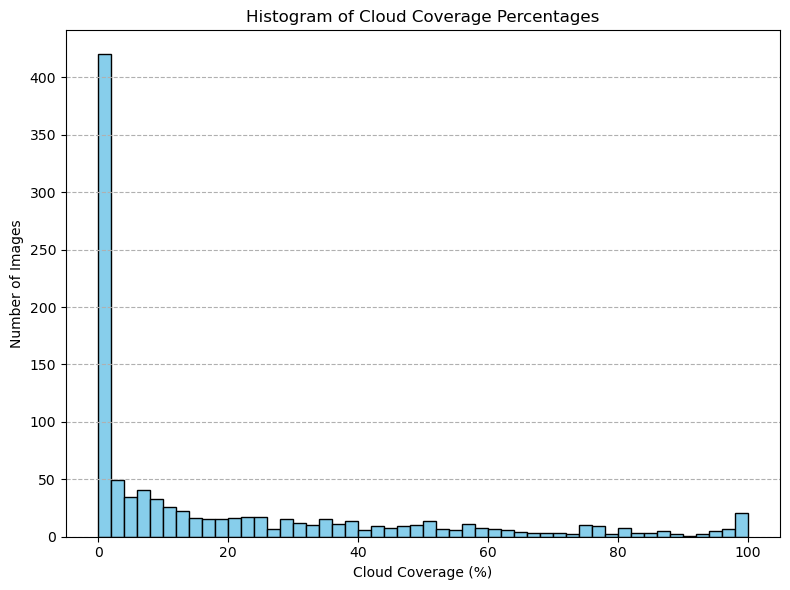

In [ ]:
def calculate_cloud_coverage(mask):
    """Calculate the percentage of pixels marked as cloud in a mask image."""
    total_pixels = mask.size
    cloud_pixels = np.sum(mask)
    return (cloud_pixels / total_pixels) * 100

def cloud_coverage_histogram():
    """ Plot a histogram of cloud coverage percentages for the training dataset."""
    cloud_percentages = []

    # Loop through all mask images and calculate cloud coverage
    for idx in range(1000):  # As there are 1000 mask images
        mask_path = f"./dataset/train_mask/train_mask_{idx}.tif"
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        cloud_coverage = calculate_cloud_coverage(mask)
        cloud_percentages.append(cloud_coverage)


        # Statistics
    mean_coverage = np.mean(cloud_percentages)
    median_coverage = np.median(cloud_percentages)
    std_coverage = np.std(cloud_percentages)
    min_coverage = np.min(cloud_percentages)
    max_coverage = np.max(cloud_percentages)

    print(f"Mean Cloud Coverage: {mean_coverage:.2f}%")
    print(f"Median Cloud Coverage: {median_coverage:.2f}%")
    print(f"Standard Deviation: {std_coverage:.2f}")
    print(f"Minimum Cloud Coverage: {min_coverage:.2f}%")
    print(f"Maximum Cloud Coverage: {max_coverage:.2f}%")
    # Plot a histogram of cloud coverage percentages
    plt.figure(figsize=(10, 6))
    plt.hist(cloud_percentages, bins=50, color='skyblue', edgecolor='black')
    plt.title('Histogram of Cloud Coverage Percentages')
    plt.xlabel('Cloud Coverage (%)')
    plt.ylabel('Number of Images')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

# Call the function to see the histogram
cloud_coverage_histogram()


On average, around `19.47%` of each image in the dataset is covered by clouds, but half of the images have a mere `5.75%` or less cloud coverage. This discrepancy, highlighted by the significantly lower median compared to the mean, indicates that while a vast majority of the dataset consists of clear to minimally cloudy images, there are a few that are heavily clouded. The dataset showcases a broad variability, as depicted by the standard deviation of `26.96%`, ranging from completely clear skies to images entirely obscured by clouds.

### Correlation Analysis

In [ ]:
import numpy as np
import cv2

# Initialize variables to store sum of intensities
sum_cloud_intensity = {band: 0 for band in BANDS}
sum_noncloud_intensity = {band: 0 for band in BANDS}
count_cloud = {band: 0 for band in BANDS}
count_noncloud = {band: 0 for band in BANDS}

# Iterate over all images
for idx in range(1000):  
    img_path = f"./dataset/train_true_color/train_true_color_{idx}.tif"
    mask_path = f"./dataset/train_mask/train_mask_{idx}.tif"
    
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    
    for band_idx, band_name in enumerate(BANDS):
        band_data = img[:, :, band_idx]
        
        cloud_pixels = band_data[mask == 1]
        noncloud_pixels = band_data[mask == 0]
        
        sum_cloud_intensity[band_name] += np.sum(cloud_pixels)
        sum_noncloud_intensity[band_name] += np.sum(noncloud_pixels)
        
        count_cloud[band_name] += len(cloud_pixels)
        count_noncloud[band_name] += len(noncloud_pixels)

# Calculate mean intensity
mean_cloud_intensity = {band: sum_cloud_intensity[band] / count_cloud[band] for band in BANDS}
mean_noncloud_intensity = {band: sum_noncloud_intensity[band] / count_noncloud[band] for band in BANDS}

print("Mean Intensity for Cloud Regions:", mean_cloud_intensity)
print("Mean Intensity for Non-Cloud Regions:", mean_noncloud_intensity)

Mean Intensity for Cloud Regions: {'B02': 5528.147553131795, 'B03': 5284.638814096459, 'B04': 5077.995628482972}
Mean Intensity for Non-Cloud Regions: {'B02': 1674.1629455920702, 'B03': 1778.2732843075305, 'B04': 1647.4195726215232}


Clouds generally reflect more light, leading to higher pixel intensity values across all bands.
The intensity difference between cloud and non-cloud regions is most pronounced in the `B02` band, followed by `B03` and then `B04`. This suggests that the `B02` band might be particularly sensitive to clouds, making it a potentially valuable feature for cloud detection.
Even though `B03` has a slightly higher intensity for non-cloud regions than `B04`, its intensity for cloud regions is also significantly higher, emphasizing its utility for differentiation.

### Spatial Patterns

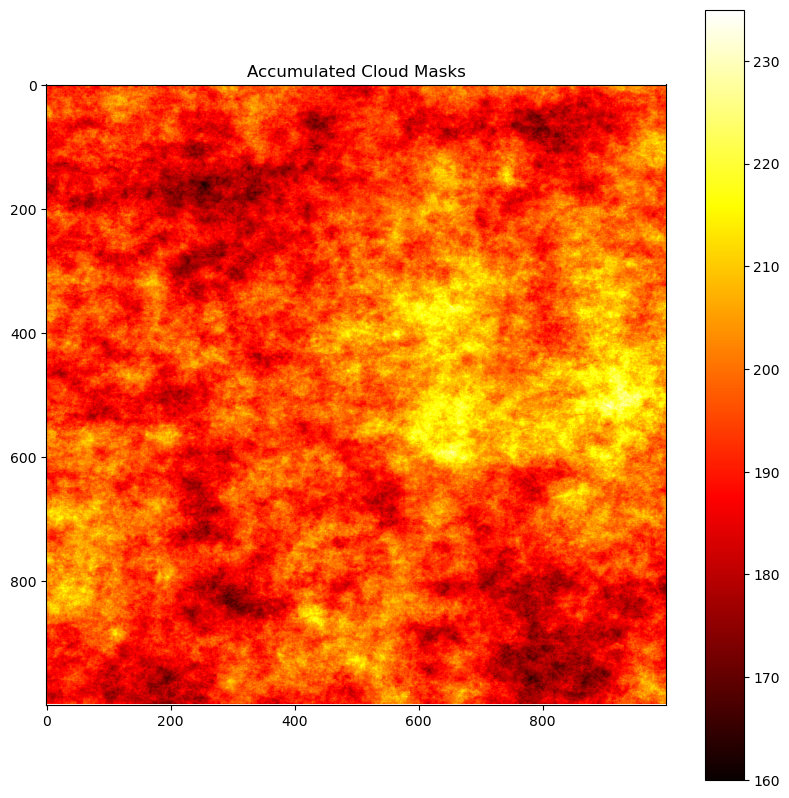

Mean Cloud Presence in Central Region: 197.8
Mean Cloud Presence in Edge Region: 148.305364


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Initialize accumulator
accumulator = np.zeros_like(cv2.imread("./dataset/train_mask/train_mask_0.tif", cv2.IMREAD_UNCHANGED))

# Aggregate masks
for idx in range(1000):
    mask_path = f"./dataset/train_mask/train_mask_{idx}.tif"
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    accumulator += mask

# Visualize the aggregated mask
plt.figure(figsize=(10, 10))
plt.imshow(accumulator, cmap='hot')
plt.colorbar()
plt.title('Accumulated Cloud Masks')
plt.show()


# Define central and edge regions
height, width = accumulator.shape
center_h, center_w = height // 2, width // 2
central_region = accumulator[center_h - 25:center_h + 25, center_w - 25:center_w + 25]
edge_region = accumulator - cv2.resize(central_region, (width, height))

# Compute mean cloud presence in regions
mean_center = np.mean(central_region)
mean_edge = np.mean(edge_region)

print(f"Mean Cloud Presence in Central Region: {mean_center}")
print(f"Mean Cloud Presence in Edge Region: {mean_edge}")

Percentage Difference between Central and Edge regions:

$$
\text{Percentage Difference} = \left( \frac{\text{Central} - \text{Edge}}{\text{Edge}} \right) \times 100\% = 33\%
$$

Clouds appear 33% more often in the center of images than at the edges. This pattern may suggests the model should be focused more on central regions.

### Anomalies detection (might delete)

In [ ]:
image_paths = [f"{PATH_IMG_ROOT}train_true_color_{i}.tif" for i in range(1000)]

# Collect statistics about each image
image_statistics = []

for path in image_paths:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    
    # Calculate mean and standard deviation for the image
    mean_intensity = np.mean(img)
    std_deviation = np.std(img)
    image_statistics.append((path, mean_intensity, std_deviation))

# Define thresholds
mean_global_intensity = np.mean([stat[1] for stat in image_statistics])
std_global_intensity = np.std([stat[1] for stat in image_statistics])

anomaly_threshold_low = mean_global_intensity - 2*std_global_intensity
anomaly_threshold_high = mean_global_intensity + 2*std_global_intensity

# Detect anomalous images
anomalous_images = [stat for stat in image_statistics if stat[1] < anomaly_threshold_low or stat[1] > anomaly_threshold_high]

print(f"Number of Anomalous Images: {len(anomalous_images)}")

# List anomalous images
for anomaly in anomalous_images:
    print(f"Anomalous Image Path: {anomaly[0]}, Mean Intensity: {anomaly[1]:.2f}, Standard Deviation: {anomaly[2]:.2f}")


Number of Anomalous Images: 50
Anomalous Image Path: ./dataset/train_true_color/train_true_color_8.tif, Mean Intensity: 7293.69, Standard Deviation: 3748.16
Anomalous Image Path: ./dataset/train_true_color/train_true_color_24.tif, Mean Intensity: 9930.95, Standard Deviation: 4763.32
Anomalous Image Path: ./dataset/train_true_color/train_true_color_31.tif, Mean Intensity: 8879.59, Standard Deviation: 2609.15
Anomalous Image Path: ./dataset/train_true_color/train_true_color_61.tif, Mean Intensity: 7237.04, Standard Deviation: 3088.13
Anomalous Image Path: ./dataset/train_true_color/train_true_color_63.tif, Mean Intensity: 5919.15, Standard Deviation: 3580.61
Anomalous Image Path: ./dataset/train_true_color/train_true_color_118.tif, Mean Intensity: 7993.54, Standard Deviation: 1072.98
Anomalous Image Path: ./dataset/train_true_color/train_true_color_132.tif, Mean Intensity: 5922.09, Standard Deviation: 3842.85
Anomalous Image Path: ./dataset/train_true_color/train_true_color_157.tif, Mean

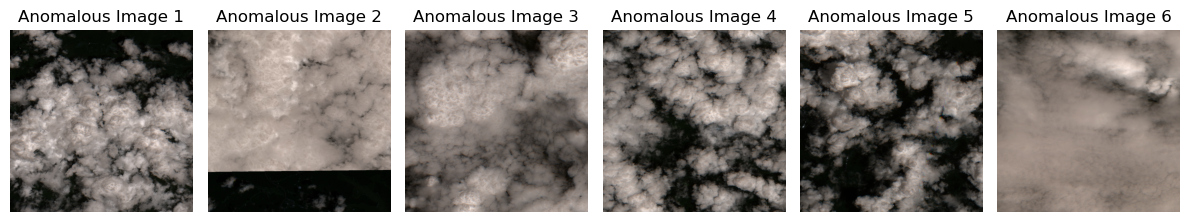

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Choose the number of anomalous images to display
num_images_to_display = 6 
anomalous_paths = [anomaly[0] for anomaly in anomalous_images[:num_images_to_display]]


# Display the selected anomalous images
plt.figure(figsize=(12, 4))
for i, path in enumerate(anomalous_paths, 1):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    
    # Normalize pixel values to the range [0, 255]
    img_normalized = ((img - np.min(img)) / (np.max(img) - np.min(img)) * 255).astype(np.uint8)
    
    plt.subplot(1, num_images_to_display, i)
    plt.imshow(img_normalized, cmap='gray')  
    plt.title(f"Anomalous Image {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


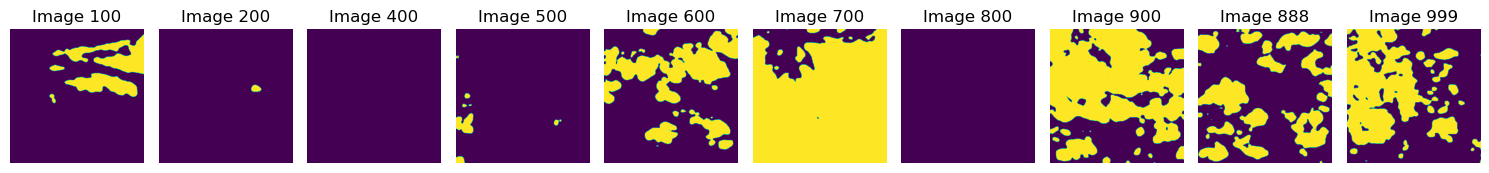

In [4]:
### This code below is for testing purposes only to check 
# the validity of the predicted data by the trained model before submission to Solafune Website
import tifffile
import matplotlib.pyplot as plt

BASE_PATH = './OUTPUT_Predictions/submission/'

fig, axes = plt.subplots(1, 10, figsize=(15, 5))  # Notice I changed NUM_IMAGES to 10 directly here

for idx, i in enumerate([100, 200, 400, 500, 600, 700, 800, 900, 888, 999]):  # Removed 20 since you have 10 axes only
    # Construct the path to the image
    path = BASE_PATH + 'evaluation_mask_' + str(i) + '.tif'
    
    # Read the image
    img = tifffile.imread(path)
    
    # Display the image
    axes[idx].imshow(img)
    axes[idx].set_title('Image ' + str(i))
    axes[idx].axis('off')  # Hide axis labels

plt.tight_layout()
plt.show()
